'c:\Users\hp\OneDrive\Desktop\kaim-ai\KAIM-1\NewsSentiment-StockPrice-Prediction' already in sys.path.

--- Starting Task 3: Correlation Analysis (All Tickers) ---

--- Loading News Data (Full Dataset) ---
News data loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB
News DataFrame Info (initial load):
None

First 5 rows of News data (initial load):
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Wee

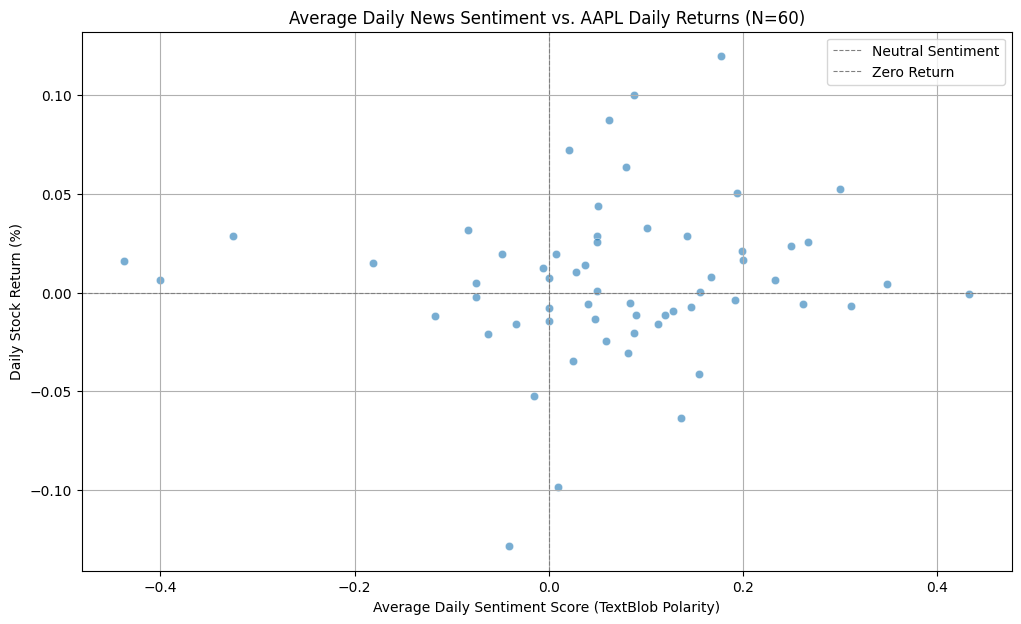

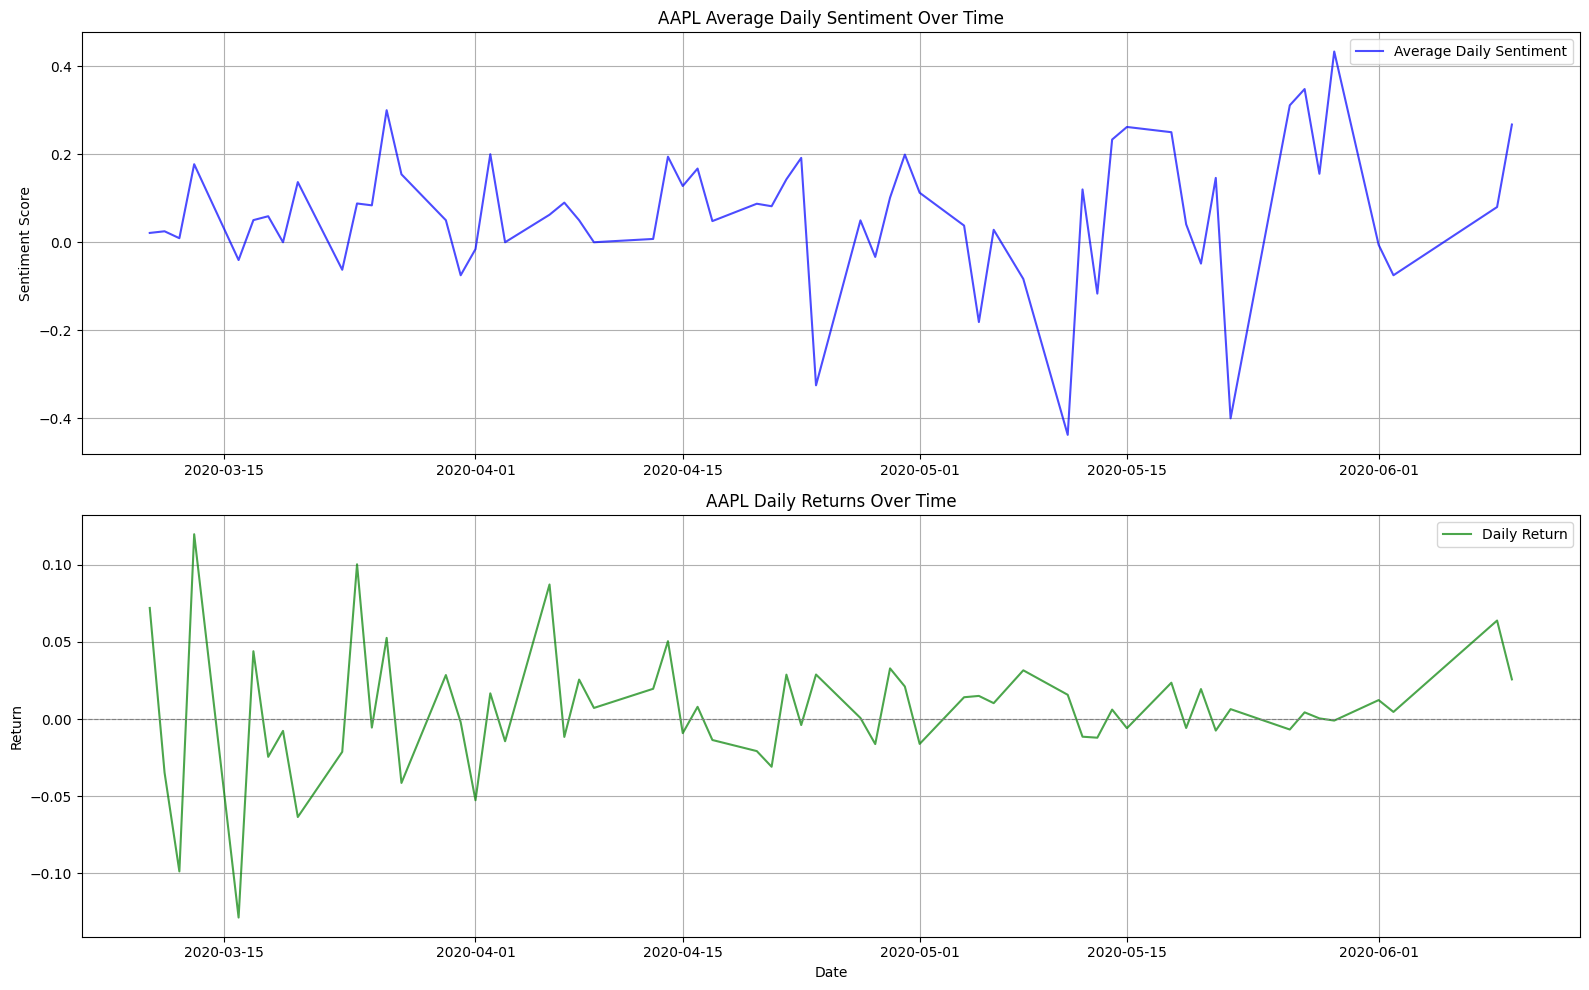


Stock data for AMZN loaded. Shape: (6846, 8)

--- Preparing data for AMZN ---
  news_df['date'] dtype after initial conversion and dropna: datetime64[ns, UTC]
  News dates for AMZN converted to timezone-naive UTC representation.
  Data prepared for AMZN. Correlation DataFrame shape: (27, 2)

Pearson Correlation between Average Daily News Sentiment and AMZN Daily Returns: -0.0451
Interpretation: Very weak or no linear correlation.
Direction: Negative.
Important Note: Correlation does not imply causation!

--- Visualizing Sentiment vs. Returns for AMZN ---


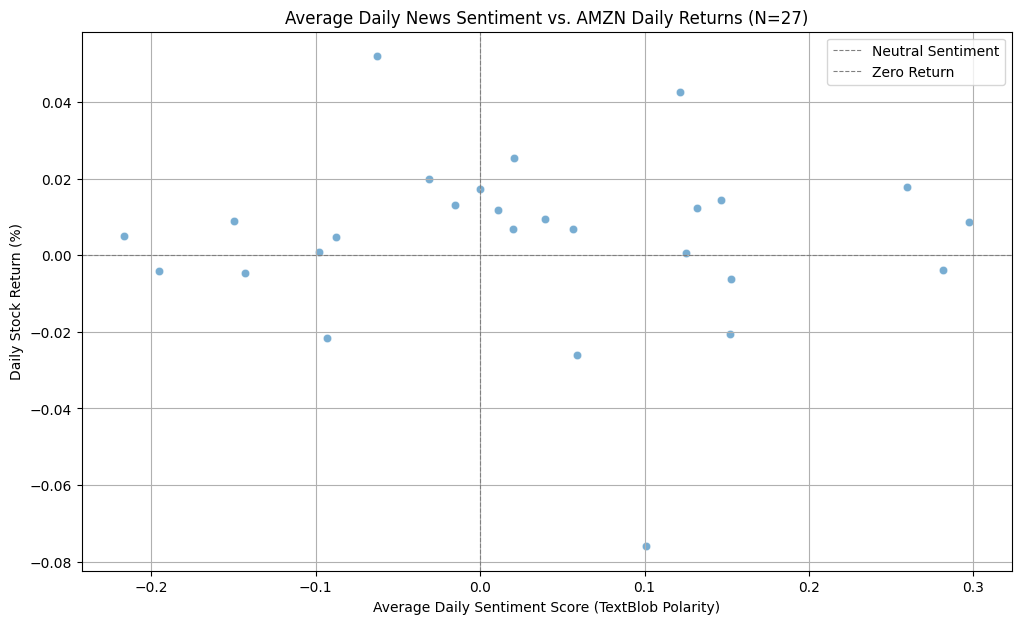

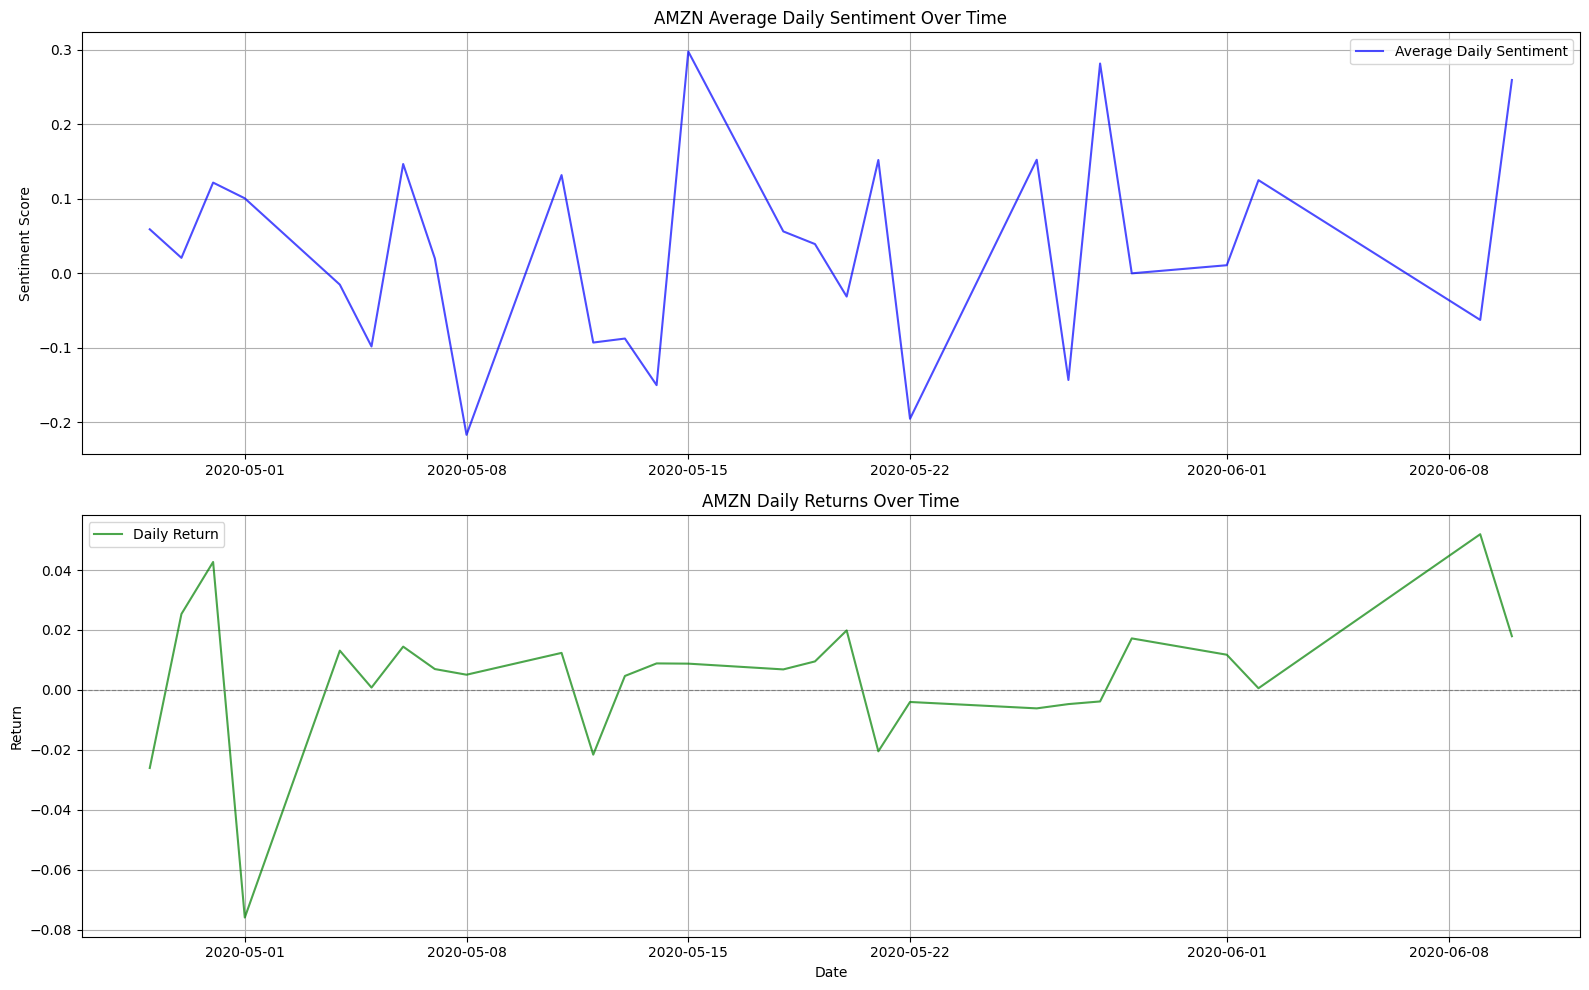


Stock data for GOOG loaded. Shape: (5020, 8)

--- Preparing data for GOOG ---
  news_df['date'] dtype after initial conversion and dropna: datetime64[ns, UTC]
  News dates for GOOG converted to timezone-naive UTC representation.
  Data prepared for GOOG. Correlation DataFrame shape: (351, 2)

Pearson Correlation between Average Daily News Sentiment and GOOG Daily Returns: 0.0496
Interpretation: Very weak or no linear correlation.
Direction: Positive.
Important Note: Correlation does not imply causation!

--- Visualizing Sentiment vs. Returns for GOOG ---


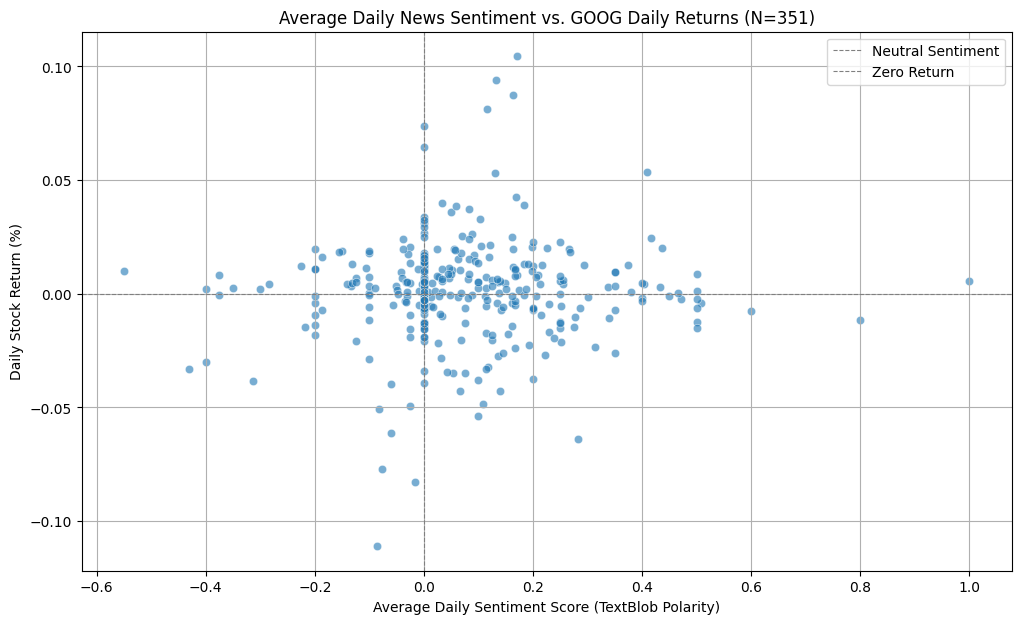

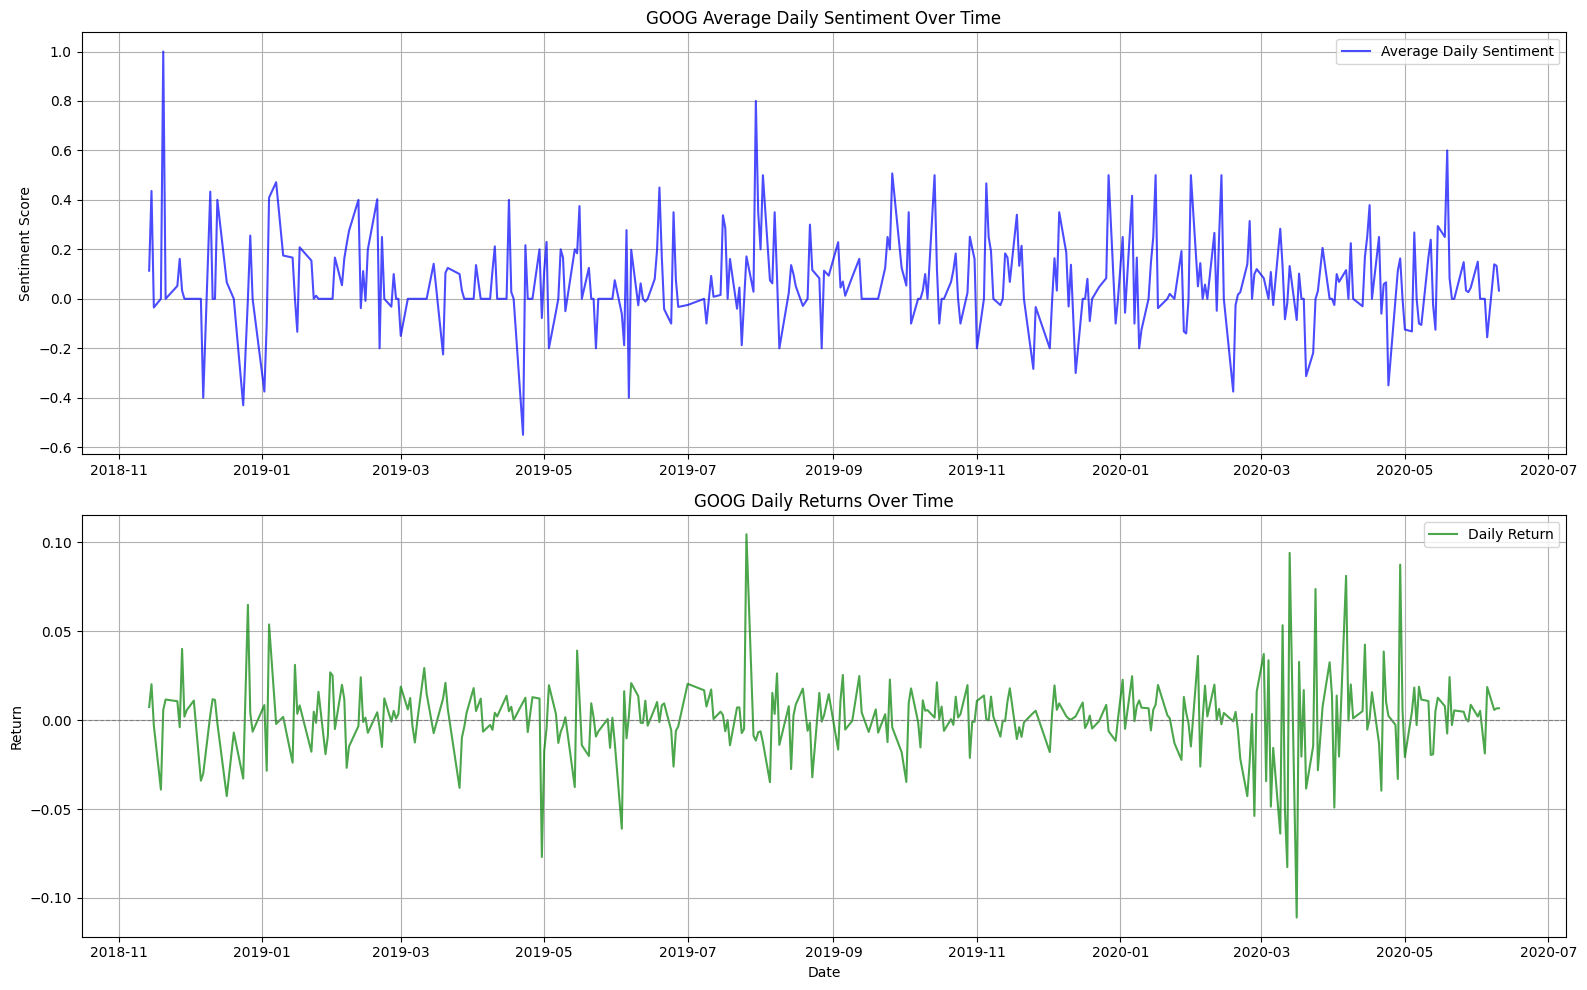


Stock data for META loaded. Shape: (2926, 8)

--- Preparing data for META ---
No news data found for ticker META. Skipping correlation.
Skipping visualization for META: No data available for correlation.

Stock data for NVDA loaded. Shape: (6421, 8)

--- Preparing data for NVDA ---
  news_df['date'] dtype after initial conversion and dropna: datetime64[ns, UTC]
  News dates for NVDA converted to timezone-naive UTC representation.
  Data prepared for NVDA. Correlation DataFrame shape: (1124, 2)

Pearson Correlation between Average Daily News Sentiment and NVDA Daily Returns: 0.1310
Interpretation: Very weak or no linear correlation.
Direction: Positive.
Important Note: Correlation does not imply causation!

--- Visualizing Sentiment vs. Returns for NVDA ---


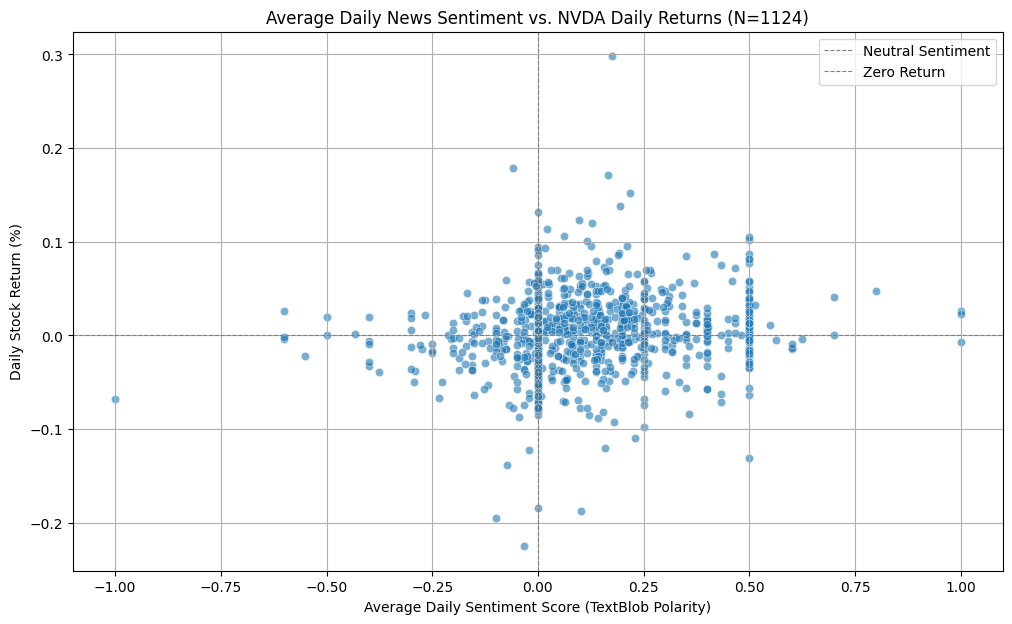

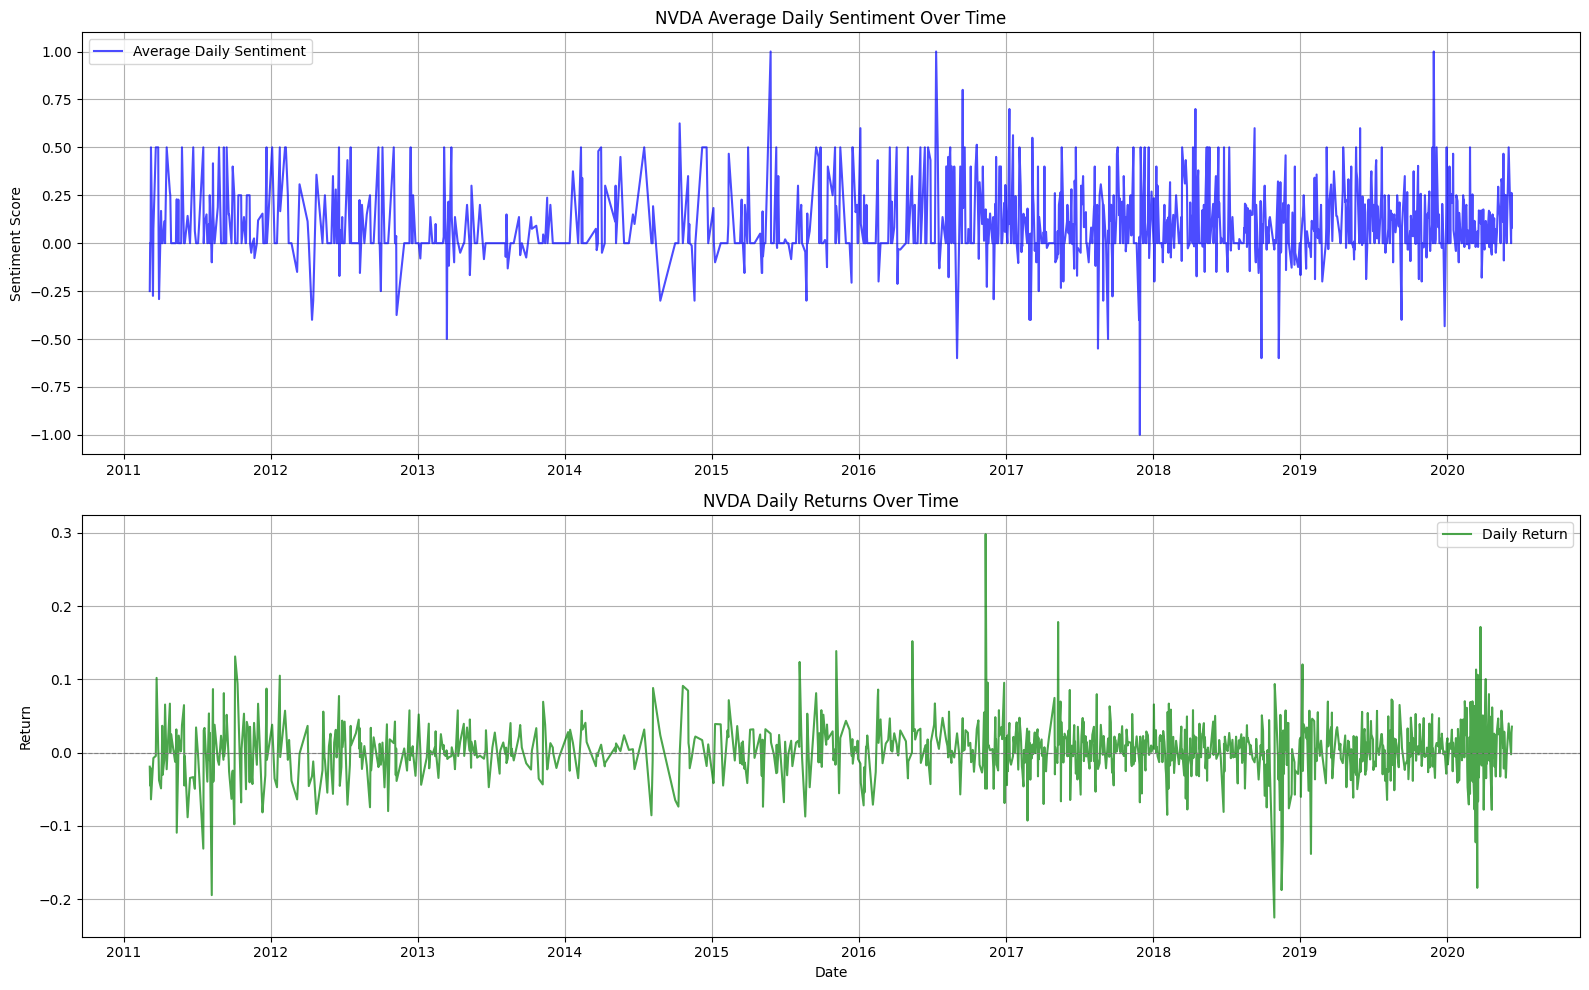


Stock data for TSLA loaded. Shape: (3545, 8)

--- Preparing data for TSLA ---
  news_df['date'] dtype after initial conversion and dropna: datetime64[ns, UTC]
  News dates for TSLA converted to timezone-naive UTC representation.
  Data prepared for TSLA. Correlation DataFrame shape: (229, 2)

Pearson Correlation between Average Daily News Sentiment and TSLA Daily Returns: 0.1238
Interpretation: Very weak or no linear correlation.
Direction: Positive.
Important Note: Correlation does not imply causation!

--- Visualizing Sentiment vs. Returns for TSLA ---


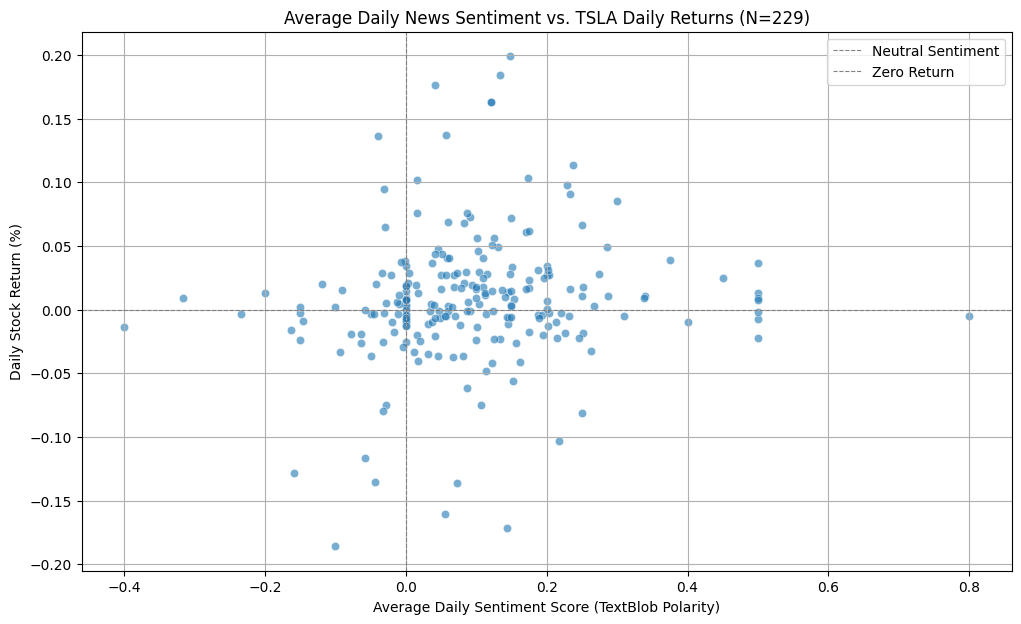

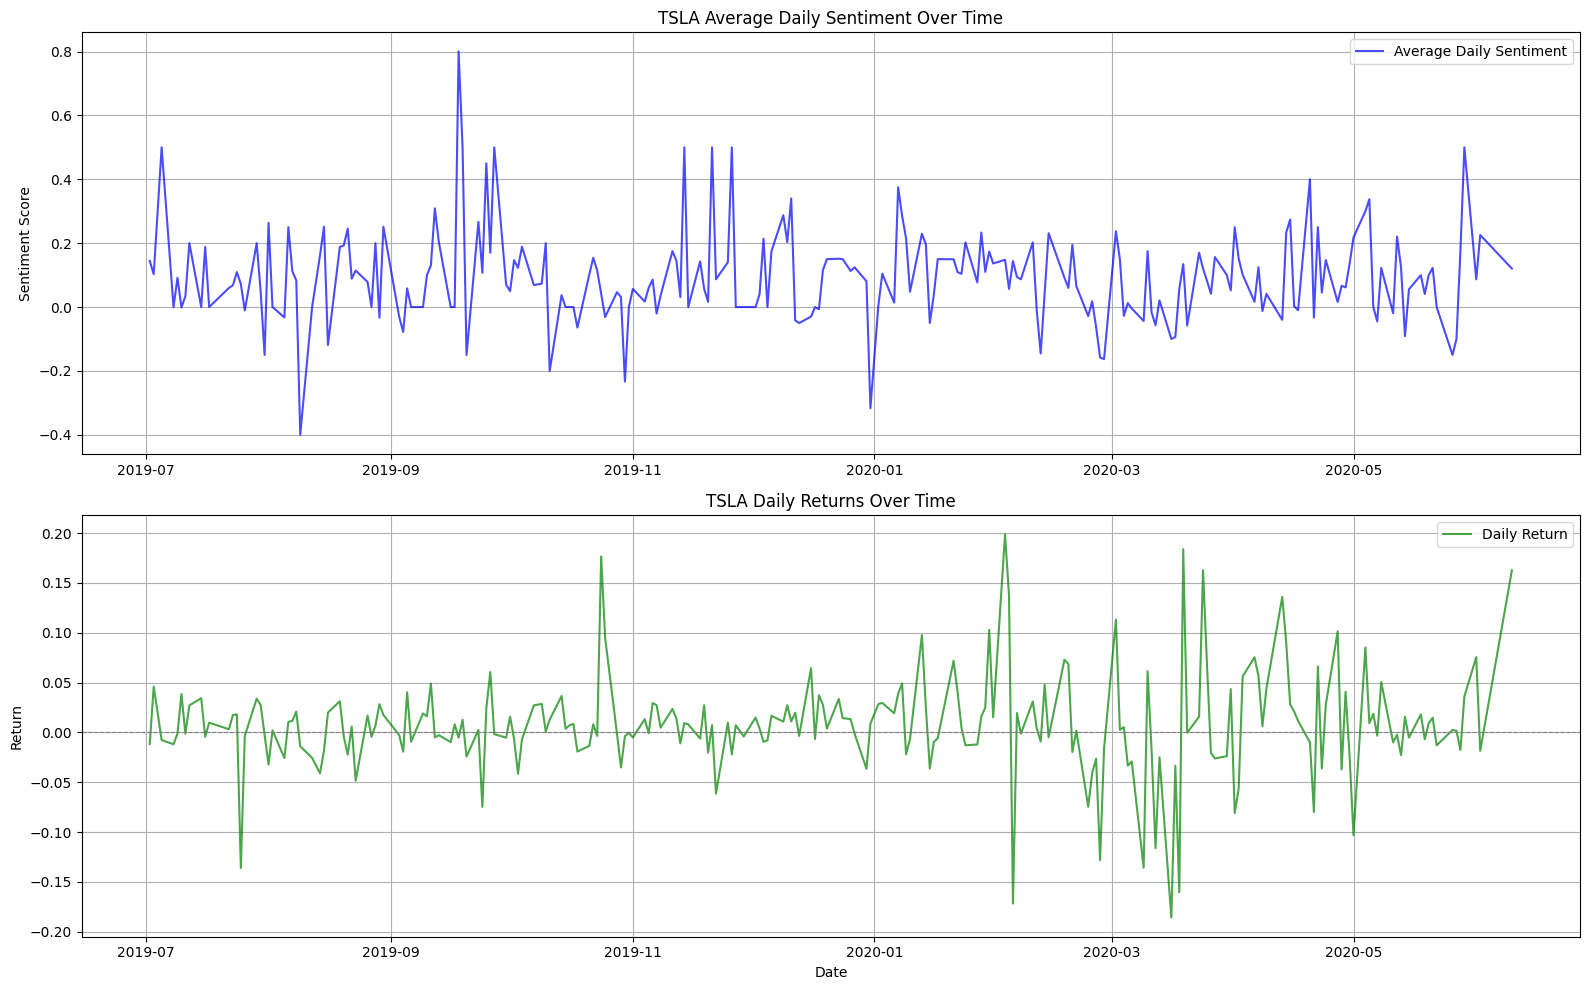


--- All Correlation Analysis for Task 3 Complete ---

Summary of Pearson Correlations:
AAPL: 0.0877
AMZN: -0.0451
GOOG: 0.0496
NVDA: 0.1310
TSLA: 0.1238

--- Task 3 Completed Successfully ---


In [ ]:
# notebooks/03_Correlation_Analysis.ipynb - Consolidated Code

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob # For sentiment analysis

# --- Project Setup: Ensure src module is discoverable ---
def find_project_root(current_path):
    path = current_path
    while path != os.path.dirname(path):
        if (os.path.isdir(os.path.join(path, 'src')) and
            os.path.isdir(os.path.join(path, 'data')) and
            os.path.isdir(os.path.join(path, 'notebooks'))):
            return path
        path = os.path.dirname(path)
    return current_path

current_working_dir = os.getcwd()
project_root = find_project_root(current_working_dir)

if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added '{project_root}' to sys.path for module imports.")
else:
    print(f"'{project_root}' already in sys.path.")

# Import configuration variables from your src.config
from src.config import NEWS_RAW_PATH, STOCK_DATA_DIR, STOCK_TICKERS

print("\n--- Starting Task 3: Correlation Analysis (All Tickers) ---")

# --- Load News Data (Once) ---
print("\n--- Loading News Data (Full Dataset) ---")
try:
    # Do NOT parse_dates here, handle it in next step for mixed formats
    news_df_raw = pd.read_csv(NEWS_RAW_PATH) 
    print("News data loaded successfully.")
    print(f"News DataFrame Info (initial load):\n{news_df_raw.info()}") # Added \n for cleaner output
    print("\nFirst 5 rows of News data (initial load):")
    print(news_df_raw.head())
except FileNotFoundError:
    print(f"CRITICAL ERROR: News data file not found at {NEWS_RAW_PATH}.")
    sys.exit("Exiting: News data file not found.")
except Exception as e:
    print(f"CRITICAL ERROR: Could not load news data: {e}")
    sys.exit("Exiting: News data loading failed.")

if news_df_raw.empty:
    sys.exit("Exiting: News DataFrame is empty after loading.")


# --- Function for Date Alignment and Sentiment Analysis ---
# Encapsulating this logic as it will be applied per stock-news subset
def prepare_news_and_stock_data_for_correlation(news_data, stock_data, ticker_symbol):
    print(f"\n--- Preparing data for {ticker_symbol} ---")

    # Filter news for the current ticker
    ticker_news_df = news_data[news_data['stock'] == ticker_symbol].copy()
    if ticker_news_df.empty:
        print(f"No news data found for ticker {ticker_symbol}. Skipping correlation.")
        return pd.DataFrame() # Return empty DataFrame

    # 1. Process News DataFrame 'date' column
    # Step 1.1: Convert to datetime, coercing errors, and using 'mixed' format with utc=True
    # This is the CRITICAL FIX. It forces datetime64[ns, UTC] dtype even with mixed offsets.
    ticker_news_df['date'] = pd.to_datetime(ticker_news_df['date'], errors='coerce', format='mixed', utc=True)
    
    # Step 1.2: IMMEDIATELY drop rows where date conversion failed (became NaT)
    initial_rows = len(ticker_news_df)
    ticker_news_df.dropna(subset=['date'], inplace=True)
    if len(ticker_news_df) < initial_rows:
        print(f"Dropped {initial_rows - len(ticker_news_df)} rows from news_df for {ticker_symbol} due to unparseable dates.")
    
    # Verify dtype after initial conversion and dropna
    print(f"  news_df['date'] dtype after initial conversion and dropna: {ticker_news_df['date'].dtype}")

    # Step 1.3: Convert to timezone-naive (strip timezone) for daily alignment
   
    ticker_news_df['date'] = ticker_news_df['date'].dt.tz_localize(None)
    print(f"  News dates for {ticker_symbol} converted to timezone-naive UTC representation.")

    # Step 1.4: Extract only the date part (YYYY-MM-DD) for daily alignment
    ticker_news_df['date_only'] = ticker_news_df['date'].dt.floor('D')
    
    # Step 1.5: Set 'date_only' as the index for news_df for merging
    ticker_news_df.set_index('date_only', inplace=True)
    ticker_news_df.sort_index(inplace=True)

    # 2. Process Stock DataFrame Index
    stock_data.index = stock_data.index.floor('D')
    stock_data.sort_index(inplace=True)

    # 3. Aggregate news headlines by date (if multiple on same day)
    daily_news_headlines = ticker_news_df.groupby(ticker_news_df.index)['headline'].apply(lambda x: ' '.join(x)).rename('combined_headline')

    # 4. Merge aggregated daily news headlines with daily stock data
    merged_df = pd.merge(
        stock_data,
        daily_news_headlines,
        left_index=True,
        right_index=True,
        how='inner'
    )
    if merged_df.empty:
        print(f"  Merged DataFrame is empty for {ticker_symbol}. No common dates found.")
        return pd.DataFrame()

    # --- Sentiment Analysis ---
    def get_sentiment_polarity(text):
        if pd.isna(text):
            return 0.0
        return TextBlob(str(text)).sentiment.polarity
    
    merged_df['sentiment_score'] = merged_df['combined_headline'].apply(get_sentiment_polarity)

    # --- Calculate Daily Stock Returns ---
    merged_df['Daily_Return'] = merged_df['Close'].pct_change()
    
    # Prepare final correlation_df
    correlation_df = merged_df[['Daily_Return', 'sentiment_score']].dropna()
    
    print(f"  Data prepared for {ticker_symbol}. Correlation DataFrame shape: {correlation_df.shape}")
    return correlation_df


# --- Main Loop for All Tickers ---
all_tickers_correlation_results = {}
for ticker in STOCK_TICKERS:
    # Load stock data for current ticker
    stock_file_name = f"{ticker}_historical_data.csv"
    stock_file_path = os.path.join(STOCK_DATA_DIR, stock_file_name)
    
    try:
        current_stock_df = pd.read_csv(stock_file_path, parse_dates=True, index_col='Date')
        current_stock_df.columns = [col.replace(' ', '_') for col in current_stock_df.columns]
        if 'Adj_Close' in current_stock_df.columns and 'Close' not in current_stock_df.columns:
            current_stock_df['Close'] = current_stock_df['Adj_Close']
        current_stock_df.dropna(inplace=True)
        print(f"\nStock data for {ticker} loaded. Shape: {current_stock_df.shape}") # Added \n for cleaner output
    except FileNotFoundError:
        print(f"\nERROR: Stock data for {ticker} not found at {stock_file_path}. Skipping.")
        continue
    except Exception as e:
        print(f"\nERROR: An unexpected error occurred loading stock data for {ticker}: {e}. Skipping.")
        continue

    # Prepare data for current ticker
    correlation_data_for_ticker = prepare_news_and_stock_data_for_correlation(news_df_raw, current_stock_df, ticker)

    if not correlation_data_for_ticker.empty:
        # --- Correlation Analysis ---
        correlation = correlation_data_for_ticker['Daily_Return'].corr(correlation_data_for_ticker['sentiment_score'])
        all_tickers_correlation_results[ticker] = correlation
        
        print(f"\nPearson Correlation between Average Daily News Sentiment and {ticker} Daily Returns: {correlation:.4f}")

        abs_correlation = abs(correlation)
        if abs_correlation >= 0.7:
            print("Interpretation: Strong correlation.")
        elif abs_correlation >= 0.5:
            print("Interpretation: Moderate correlation.")
        elif abs_correlation >= 0.3:
            print("Interpretation: Weak correlation.")
        else:
            print("Interpretation: Very weak or no linear correlation.")

        if correlation > 0:
            print("Direction: Positive.")
        elif correlation < 0:
            print("Direction: Negative.")
        else:
            print("Direction: No linear relationship.")
        print("Important Note: Correlation does not imply causation!")


        # --- Visualization of Correlation ---
        print(f"\n--- Visualizing Sentiment vs. Returns for {ticker} ---")
        
        # Scatter Plot
        plt.figure(figsize=(12, 7))
        sns.scatterplot(x='sentiment_score', y='Daily_Return', data=correlation_data_for_ticker, alpha=0.6)
        plt.title(f'Average Daily News Sentiment vs. {ticker} Daily Returns (N={len(correlation_data_for_ticker)})')
        plt.xlabel('Average Daily Sentiment Score (TextBlob Polarity)')
        plt.ylabel('Daily Stock Return (%)')
        plt.grid(True)
        plt.axvline(0, color='gray', linestyle='--', linewidth=0.8, label='Neutral Sentiment')
        plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, label='Zero Return')
        plt.legend()
        plt.show()

        # Time series plots of Sentiment and Returns
        plt.figure(figsize=(16, 10))

        plt.subplot(2, 1, 1)
        plt.plot(correlation_data_for_ticker.index, correlation_data_for_ticker['sentiment_score'], label='Average Daily Sentiment', color='blue', alpha=0.7)
        plt.title(f'{ticker} Average Daily Sentiment Over Time')
        plt.ylabel('Sentiment Score')
        plt.grid(True)
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(correlation_data_for_ticker.index, correlation_data_for_ticker['Daily_Return'], label='Daily Return', color='green', alpha=0.7)
        plt.title(f'{ticker} Daily Returns Over Time')
        plt.ylabel('Return')
        plt.xlabel('Date')
        plt.grid(True)
        plt.legend()
        plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)

        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping visualization for {ticker}: No data available for correlation.")

print("\n--- All Correlation Analysis for Task 3 Complete ---")
print("\nSummary of Pearson Correlations:")
for ticker, corr in all_tickers_correlation_results.items():
    print(f"{ticker}: {corr:.4f}")
print("\n--- Task 3 Completed Successfully ---")
